In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
from torchvision import transforms, datasets
BATCH_SIZE = 128
transform = transforms.Compose([                                
                                transforms.RandomHorizontalFlip(p=.5),
                                transforms.RandomCrop(32, padding=4),
                                transforms.ToTensor()
])
val_transform = transforms.Compose([
                                    transforms.Resize(32),
                                    transforms.ToTensor()
])

img_datasets = {'train': datasets.CIFAR10('./data', train=True, download=True, transform=transform), 
            'val': datasets.CIFAR10('./data', train=False, download=True, transform=val_transform) }
dataloaders = {x: torch.utils.data.DataLoader(img_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=4,drop_last=True if x=='train' else False) for x in ['train', 'val']}
dataset_sizes = {x: len(img_datasets[x]) for x in ['train', 'val']}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [156]:
import time
import copy
import math
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    print(f"Train on {dataset_sizes['train']}, validate on {dataset_sizes['val']} images")
    since = time.time()

    running_loss = []
    running_batch_sizes = []
    running_corrects = []
    val_loss = []
    val_corrects = []
    eval_window = 150

    for epoch in range(num_epochs):
      
        model.train()
        for inputs, labels in dataloaders['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss.append(loss.item() * inputs.size(0))
            running_batch_sizes.append(inputs.size(0))
            running_corrects.append(torch.sum(preds == labels.data).item())

            scheduler.step()

        print('Epoch: {}\tLoss: {:.4f}\tAcc: {:.4f}'.format(epoch, np.sum(running_loss[-math.ceil(dataset_sizes['train'] / BATCH_SIZE):]) / dataset_sizes['train'], np.sum(running_corrects[-math.ceil(dataset_sizes['train'] / BATCH_SIZE):]) / dataset_sizes['train']))

        model.eval()
        total_loss = 0.0
        total_corrects = 0
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

            total_loss += loss.item() * inputs.size(0)
            total_corrects += torch.sum(preds == labels.data)

        val_loss.append(total_loss / dataset_sizes['val'])
        val_corrects.append(total_corrects.double() / dataset_sizes['val'])
        print('Eval:\tLoss: {:.4f}\tAcc: {:.4f}'.format(val_loss[-1], val_corrects[-1]))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return model, running_loss, running_batch_sizes, running_corrects, val_loss, val_corrects

In [164]:
from torchvision import models
import torch.optim as optim
import torch.nn as nn
from torch.optim import lr_scheduler
import resnet
config = {
        'block_sizes':[3,3,3],
        'feature_sizes': [16,16,32,64],
        'is_bottleneck': False
}

CIFAR_CONFIG = {
    'initial_kernel_size': 3,
    'initial_stride': 1,
    'initial_max_pool': False,
    'classes': 10,
    'color_channels': 3
}

model= resnet.ResNet(c_channels=CIFAR_CONFIG['color_channels'],
              classes=CIFAR_CONFIG['classes'],
              block_sizes=config['block_sizes'],
              feature_sizes=config['feature_sizes'],
              is_bottleneck=config['is_bottleneck'],
              initial_kernel_size=CIFAR_CONFIG['initial_kernel_size'],
              skip_connections=True,
              initial_stride=CIFAR_CONFIG['initial_stride'],
              initial_max_pool=CIFAR_CONFIG['initial_max_pool'])

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=32000, gamma=0.1)

In [165]:
NUM_EPOCHS = 164
trained_model, loss, bs, corrects, val_loss, val_acc  = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=NUM_EPOCHS)

Train on 50000, validate on 10000 images
Epoch: 0	Loss: 1.8349	Acc: 0.3137
Eval:	Loss: 1.5947	Acc: 0.4121
Epoch: 1	Loss: 1.2763	Acc: 0.5372
Eval:	Loss: 1.2756	Acc: 0.5652
Epoch: 2	Loss: 0.9838	Acc: 0.6497
Eval:	Loss: 1.0781	Acc: 0.6118
Epoch: 3	Loss: 0.8095	Acc: 0.7181
Eval:	Loss: 0.9114	Acc: 0.6934
Epoch: 4	Loss: 0.7026	Acc: 0.7547
Eval:	Loss: 0.8313	Acc: 0.7194
Epoch: 5	Loss: 0.6308	Acc: 0.7813
Eval:	Loss: 0.8515	Acc: 0.7413
Epoch: 6	Loss: 0.5844	Acc: 0.7980
Eval:	Loss: 0.6839	Acc: 0.7716
Epoch: 7	Loss: 0.5508	Acc: 0.8107
Eval:	Loss: 0.6798	Acc: 0.7767
Epoch: 8	Loss: 0.5171	Acc: 0.8215
Eval:	Loss: 0.6625	Acc: 0.7855
Epoch: 9	Loss: 0.4942	Acc: 0.8313
Eval:	Loss: 0.7325	Acc: 0.7636
Epoch: 10	Loss: 0.4722	Acc: 0.8386
Eval:	Loss: 0.7992	Acc: 0.7423
Epoch: 11	Loss: 0.4578	Acc: 0.8425
Eval:	Loss: 0.5568	Acc: 0.8112
Epoch: 12	Loss: 0.4340	Acc: 0.8504
Eval:	Loss: 0.8463	Acc: 0.7391
Epoch: 13	Loss: 0.4193	Acc: 0.8547
Eval:	Loss: 0.5258	Acc: 0.8261
Epoch: 14	Loss: 0.4086	Acc: 0.8580
Eval:	Loss

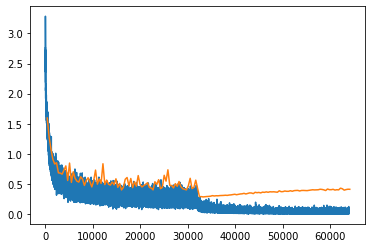

In [166]:
import matplotlib.pyplot as plt

loss_steps = [math.ceil(dataset_sizes['train'] / BATCH_SIZE) * i for i in range(1,NUM_EPOCHS+1)]

plt.plot(np.divide(loss,bs))
plt.plot(loss_steps, val_loss)
plt.show()

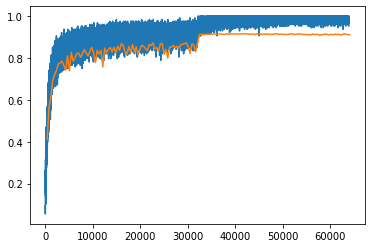

In [167]:
plt.plot(np.divide(corrects,bs))
plt.plot(loss_steps, val_acc)
plt.show()